In [1]:
import cv2
import tensorflow as tf
from PIL import Image
import numpy as np
import os

model_path = '../models/model.tflite'


2023-01-26 20:39:27.886471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the labels into a list
classes = ['???'] * 5
label_map={1: "dart", 2: "twenty", 3: "eleven", 4: "six", 5: "three"}
for label_id, label_name in label_map.items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  prepared_data = []
  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    prepared_data.append({
      "bounding_box": [xmin, ymin, xmax, ymax],
      "class_id": class_id,
    })

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8, prepared_data

[{'bounding_box': [321, 40, 380, 99], 'class_id': 1}, {'bounding_box': [39, 449, 89, 492], 'class_id': 2}, {'bounding_box': [715, 384, 760, 410], 'class_id': 3}, {'bounding_box': [508, 332, 538, 370], 'class_id': 0}, {'bounding_box': [410, 697, 434, 733], 'class_id': 4}, {'bounding_box': [259, 442, 284, 473], 'class_id': 0}]


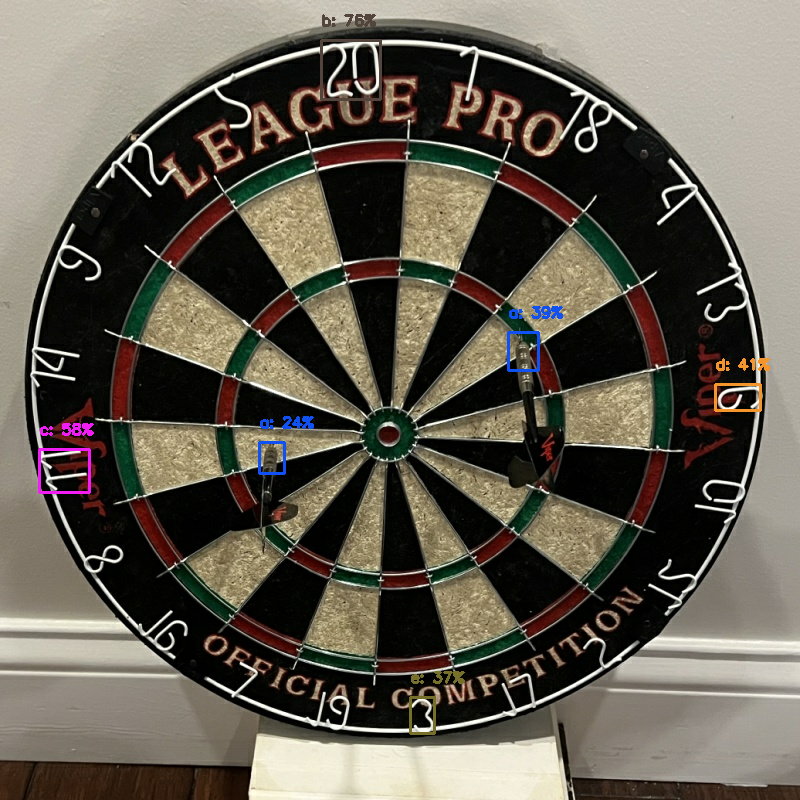

In [4]:
INPUT_IMAGE_URL = "../data/cropped/IMG_8561.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.2 #@param {type:"number"}


# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image, boundings = run_odt_and_draw_results(
    INPUT_IMAGE_URL,
    interpreter,
    threshold=DETECTION_THRESHOLD
)
print(boundings)

# Show the detection result
Image.fromarray(detection_result_image)

In [ ]:
np.save("../data/boundings/IMG_8561_boundings.npy", boundings)

In [ ]:
boundings

[{'bounding_box': [321, 40, 380, 99], 'class_id': 1},
 {'bounding_box': [39, 449, 89, 492], 'class_id': 2},
 {'bounding_box': [715, 384, 760, 410], 'class_id': 3},
 {'bounding_box': [508, 332, 538, 370], 'class_id': 0},
 {'bounding_box': [410, 697, 434, 733], 'class_id': 4},
 {'bounding_box': [259, 442, 284, 473], 'class_id': 0}]